In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn', 'seaborn-white', 'seaborn-ticks', 'dark_background', 'Solarize_Light2', 'grayscale', 'seaborn-pastel', 'seaborn-poster', '_classic_test', 'seaborn-paper', 'seaborn-muted', 'seaborn-deep', 'bmh', 'ggplot', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-colorblind', 'classic', 'seaborn-darkgrid', 'fast', 'seaborn-notebook', 'seaborn-bright', 'fivethirtyeight', 'seaborn-whitegrid']


In [43]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [44]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [45]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

ps_all = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    ps = np.abs(np.fft.fft(data))**2

    if ps_all is None:
        ps_all = ps
    else:
        ps_all = np.vstack((ps_all, ps))


In [46]:
freqs = np.fft.fftfreq(data.size, delta_t)
idx = np.argsort(freqs)

ps_std = np.std(ps_all, axis=0)
ps_mean = np.mean(ps_all, axis=0)

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


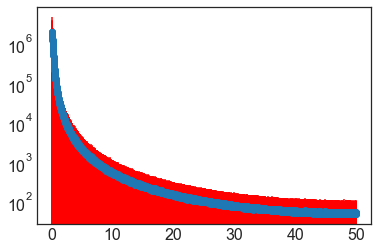

In [47]:
plt.errorbar(freqs[idx][N/2:],ps_mean[idx][N/2:],yerr=ps_std[idx][N/2:],fmt="o",ecolor='red')
plt.yscale('log')
#plt.xscale('log')

In [48]:
print(pearsonr(ps_all.T[9000],ps_all.T[9001]))

(-0.01890757228690829, 0.55036351028500929)
